In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from geopandas import GeoDataFrame

# Load the shapefile (FDep data)
fdep_file = "EDI_data/inserm_fdep_2015_metropole_com17_j.shp"  # Replace with your file path
fdep_gdf = gpd.read_file(fdep_file)

# Load the CSV file (FEDI data)
fedi_file = "EDI_data/edi2017-iris.csv"  # Replace with your file path
fedi_df = pd.read_csv(fedi_file)

# Load the expo shapefile for pollutants
expo_file = r"data\2-output-data\s0\ug_PM25_RH50\2019\expo-shp"  # Replace with your file path
expo_gdf = gpd.read_file(expo_file)

# Display top 10 rows of each dataset to understand the structure
print("Top 10 rows of FDep (Shapefile):")
print(fdep_gdf.head(10))
print("\nColumns in FDep:", fdep_gdf.columns)

print("\nTop 10 rows of FEDI (CSV):")
print(fedi_df.head(10))
print("\nColumns in FEDI:", fedi_df.columns)

print("\nTop 10 rows of Expo (Shapefile):")
print(expo_gdf.head(10))
print("\nColumns in Expo:", expo_gdf.columns)

Top 10 rows of FDep (Shapefile):
   gid  c_gid                      c_id          c_nom_com         c_nom_com_  \
0    1      1  BDCSURCO0000000009615714  Ourdis-Cotdoussan  OURDIS-COTDOUSSAN   
1    2      2  BDCSURCO0000000009603194           Gaillard           GAILLARD   
2    3      3  BDCSURCO0000000009592112    Rives d'Andaine    RIVES D'ANDAINE   
3    4      4  BDCSURCO0000000009590907          Flexbourg          FLEXBOURG   
4    5      5  BDCSURCO0000000009611764  Cruviers-Lascours  CRUVIERS-LASCOURS   
5    6      6  BDCSURCO0000000009592575          Couptrain          COUPTRAIN   
6    7      7  BDCSURCO0000000009612187              Goult              GOULT   
7    8      8  BDCSURCO0000000009597097    Coulmier-le-Sec    COULMIER-LE-SEC   
8    9      9  BDCSURCO0000000009581615              Naves              NAVES   
9   10     10  BDCSURCO0000000009595077        Metz-Robert        METZ-ROBERT   

  c_insee_co        c_statut c_insee_ar        c_nom_dep c_insee_de  \
0   

In [2]:
# Merge datasets based on common geographic names
merged_df = fdep_gdf[["c_nom_com", "t1_q5"]].merge(fedi_df[["LIBCOM", "quintileedi2017"]], left_on="c_nom_com", right_on="LIBCOM")

# Check the first few rows of the merged dataset
print("Top 10 rows of merged data:")
print(merged_df.head(10))

# Optionally check for any issues with the merge
print(f"Number of rows after merging: {len(merged_df)}")


Top 10 rows of merged data:
           c_nom_com  t1_q5             LIBCOM  quintileedi2017
0  Ourdis-Cotdoussan      5  Ourdis-Cotdoussan                3
1           Gaillard      3           Gaillard                5
2           Gaillard      3           Gaillard                5
3           Gaillard      3           Gaillard                5
4           Gaillard      3           Gaillard                5
5    Rives d'Andaine      5    Rives d'Andaine                4
6          Flexbourg      2          Flexbourg                2
7  Cruviers-Lascours      2  Cruviers-Lascours                3
8          Couptrain      5          Couptrain                4
9              Goult      2              Goult                3
Number of rows after merging: 55794


In [3]:
# Check for common values in 'c_nom_com' (from fdep_gdf) and 'LIBCOM' (from fedi_df)
common_names = set(fdep_gdf["c_nom_com"]).intersection(fedi_df["LIBCOM"])

# Print the number of common names and a sample of them
print(f"Number of common geographic names: {len(common_names)}")
print(list(common_names)[:10])


Number of common geographic names: 32255
['Castelnau-de-Mandailles', 'Boust', 'Brochon', 'Rebeuville', 'Boisdinghem', 'Auxelles-Bas', 'Saint-Jean-de-Daye', 'Lothey', 'Jaleyrac', 'Ladirat']


Number of rows in merged_expo_df after merging and dropping NA: 447040


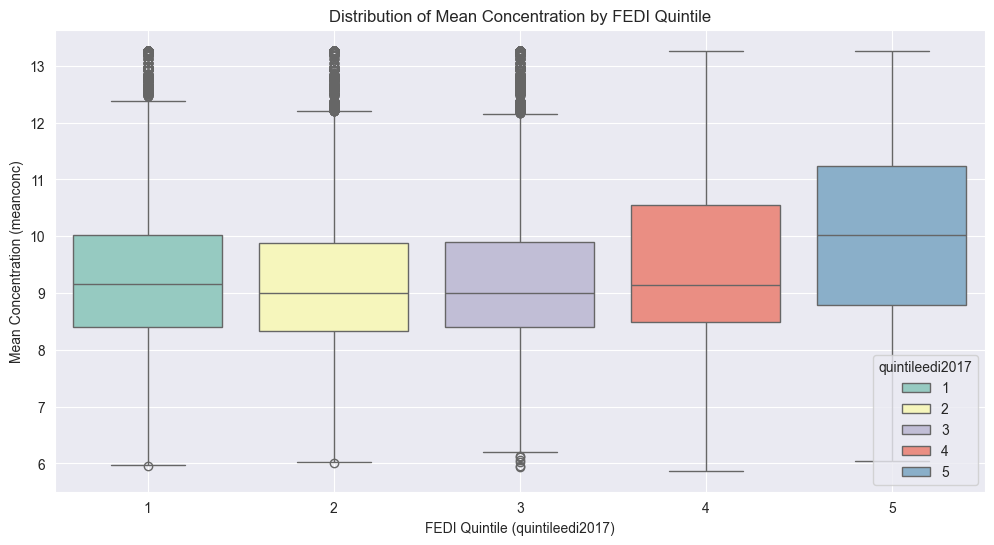

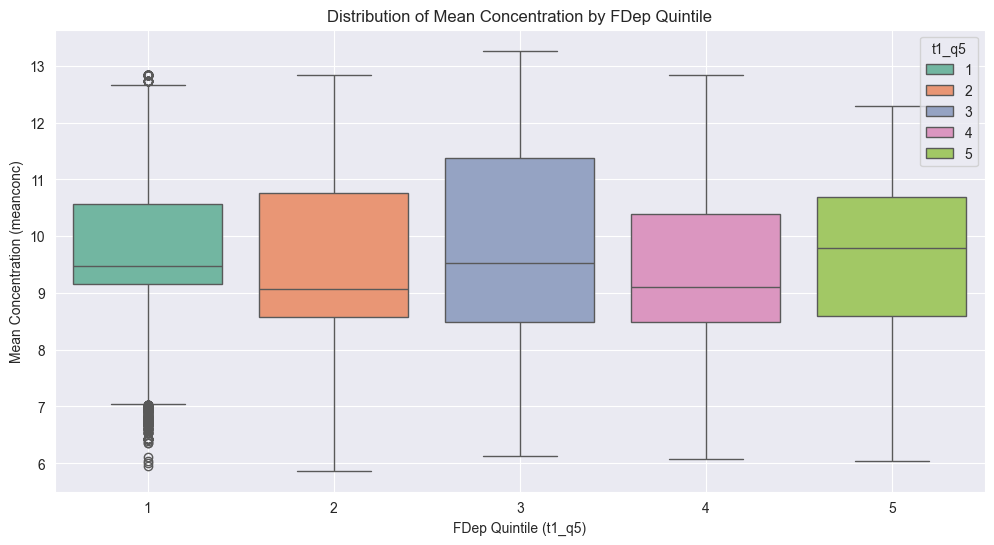

In [4]:
# Check 'meanconc' in the expo file by both quintileedi2017 and t1_q5 as categorical variables
# Merge expo_gdf with the merged_df on a common identifier ('comname' with 'LIBCOM')
if 'comname' in expo_gdf.columns and 'LIBCOM' in merged_df.columns:
    # Merge but keep only relevant columns to avoid unnecessary duplicates and reduce row count
    merged_expo_df = expo_gdf[['comname', 'meanconc']].merge(
        merged_df[['LIBCOM', 'quintileedi2017', 't1_q5']],
        left_on="comname",
        right_on="LIBCOM",
        how="inner"
    )

    # Check for missing values in 'meanconc', 'quintileedi2017', and 't1_q5'
    merged_expo_df = merged_expo_df.dropna(subset=['meanconc', 'quintileedi2017', 't1_q5'])

    # Debug: Check the number of rows in merged_expo_df after merging and cleaning
    print(f"Number of rows in merged_expo_df after merging and dropping NA: {len(merged_expo_df)}")

    if len(merged_expo_df) > 0:
        # Ensure 'quintileedi2017' and 't1_q5' are treated as categorical variables
        merged_expo_df['quintileedi2017'] = merged_expo_df['quintileedi2017'].astype('category')
        merged_expo_df['t1_q5'] = merged_expo_df['t1_q5'].astype('category')

        # Create directory if it doesn't exist for saving the plots
        import os
        save_dir = "data/EDI_data"
        os.makedirs(save_dir, exist_ok=True)

        # Plot distribution of 'meanconc' by 'quintileedi2017' as a boxplot
        plt.figure(figsize=(12, 6))
        sns.boxplot(
            data=merged_expo_df,
            x='quintileedi2017',
            y='meanconc',
            hue='quintileedi2017',
            dodge=False,  # Prevents splitting by hue
            palette="Set3"
        )
        plt.xlabel("FEDI Quintile (quintileedi2017)")
        plt.ylabel("Mean Concentration (meanconc)")
        plt.title("Distribution of Mean Concentration by FEDI Quintile")
        plt.grid(True)
        plt.savefig(os.path.join(save_dir, "meanconc_by_fedi_quintile_PM.png"))
        plt.show()

        # Plot distribution of 'meanconc' by 't1_q5' as a boxplot
        plt.figure(figsize=(12, 6))
        sns.boxplot(
            data=merged_expo_df,
            x='t1_q5',
            y='meanconc',
            hue='t1_q5',
            dodge=False,  # Prevents splitting by hue
            palette="Set2"
        )
        plt.xlabel("FDep Quintile (t1_q5)")
        plt.ylabel("Mean Concentration (meanconc)")
        plt.title("Distribution of Mean Concentration by FDep Quintile")
        plt.grid(True)
        plt.savefig(os.path.join(save_dir, "meanconc_by_fdep_quintile_PM.png"))
        plt.show()
    else:
        print("Error: No data available for plotting after merging and cleaning. Check the 'comname' and 'LIBCOM' values.")
else:
    print("Error: Unable to merge expo_gdf with merged_df. Ensure both datasets have a common identifier ('comname' and 'LIBCOM').")

Number of rows in merged_expo_df after merging and dropping NA: 447040


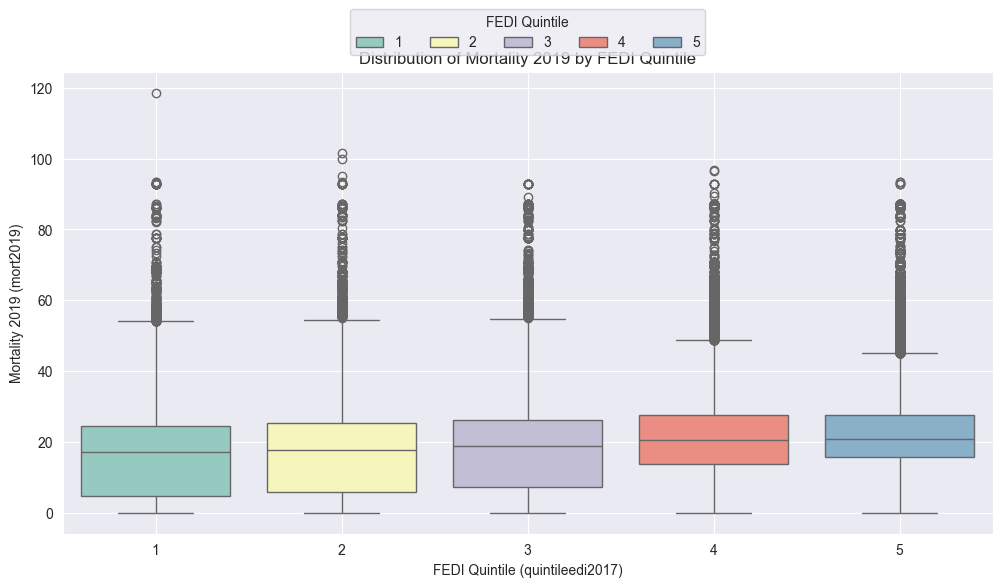

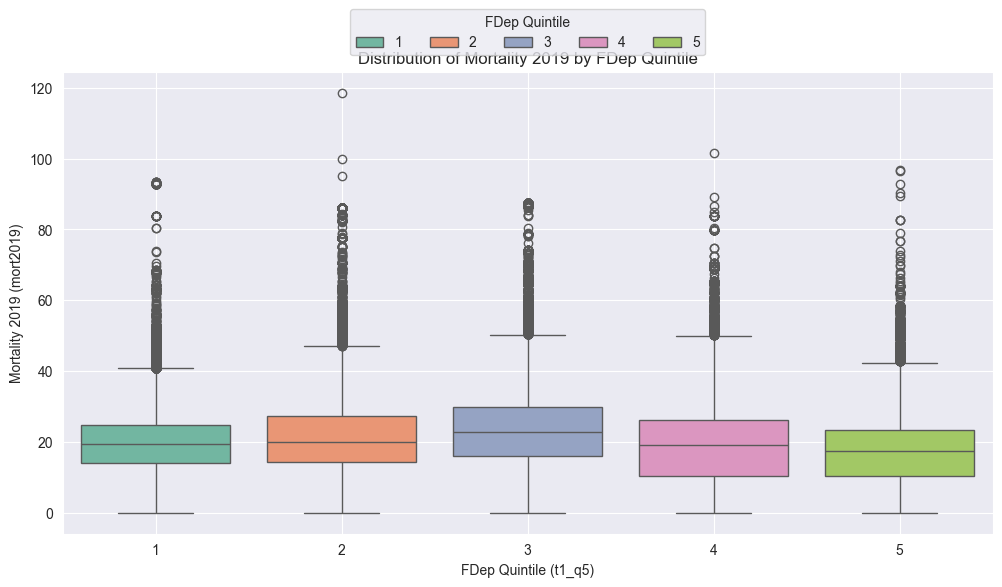

In [6]:
# Check 'mort2019' in the expo file by both quintileedi2017 and t1_q5 as categorical variables
# Merge expo_gdf with the merged_df on a common identifier ('comname' with 'LIBCOM')
if 'comname' in expo_gdf.columns and 'LIBCOM' in merged_df.columns:
    # Merge but keep only relevant columns to avoid unnecessary duplicates and reduce row count
    merged_expo_df = expo_gdf[['comname', 'mort2019']].merge(
        merged_df[['LIBCOM', 'quintileedi2017', 't1_q5']],
        left_on="comname",
        right_on="LIBCOM",
        how="inner"
    )

    # Check for missing values in 'mort2019', 'quintileedi2017', and 't1_q5'
    merged_expo_df = merged_expo_df.dropna(subset=['mort2019', 'quintileedi2017', 't1_q5'])

    # Debug: Check the number of rows in merged_expo_df after merging and cleaning
    print(f"Number of rows in merged_expo_df after merging and dropping NA: {len(merged_expo_df)}")

    if len(merged_expo_df) > 0:
        # Ensure 'quintileedi2017' and 't1_q5' are treated as categorical variables
        merged_expo_df['quintileedi2017'] = merged_expo_df['quintileedi2017'].astype('category')
        merged_expo_df['t1_q5'] = merged_expo_df['t1_q5'].astype('category')

        # Create directory if it doesn't exist for saving the plots
        import os
        save_dir = "data/EDI_data"
        os.makedirs(save_dir, exist_ok=True)

        # Plot distribution of 'mort2019' by 'quintileedi2017' as a boxplot
        plt.figure(figsize=(12, 6))
        sns.boxplot(
            data=merged_expo_df,
            x='quintileedi2017',
            y='mort2019',
            hue='quintileedi2017',
            dodge=False,  # Prevents splitting by hue
            palette="Set3"
        )
        plt.xlabel("FEDI Quintile (quintileedi2017)")
        plt.ylabel("Mortality 2019 (mort2019)")
        plt.title("Distribution of Mortality 2019 by FEDI Quintile")
        plt.grid(True)
        plt.legend(title="FEDI Quintile", bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=5)  # Move legend to top
        plt.savefig(os.path.join(save_dir, "mort2019_by_fedi_quintile_PM.png"))
        plt.show()

        # Plot distribution of 'mort2019' by 't1_q5' as a boxplot
        plt.figure(figsize=(12, 6))
        sns.boxplot(
            data=merged_expo_df,
            x='t1_q5',
            y='mort2019',
            hue='t1_q5',
            dodge=False,  # Prevents splitting by hue
            palette="Set2"
        )
        plt.xlabel("FDep Quintile (t1_q5)")
        plt.ylabel("Mortality 2019 (mort2019)")
        plt.title("Distribution of Mortality 2019 by FDep Quintile")
        plt.grid(True)
        plt.legend(title="FDep Quintile", bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=5)  # Move legend to top
        plt.savefig(os.path.join(save_dir, "mort2019_by_fdep_quintile_PM.png"))
        plt.show()
    else:
        print("Error: No data available for plotting after merging and cleaning. Check the 'comname' and 'LIBCOM' values.")
else:
    print("Error: Unable to merge expo_gdf with merged_df. Ensure both datasets have a common identifier ('comname' and 'LIBCOM').")

In [38]:
# Drop rows with missing values
merged_df = merged_df.dropna()

if merged_df.shape[0] > 0:
    x = merged_df["t1_fdep15"]
    y = merged_df["edi2017"]

    rmse = np.sqrt(mean_squared_error(y, x))
    r2 = r2_score(y, x)

    print(f"RMSE: {rmse}")
    print(f"R²: {r2}")
else:
    print("Error: No data after merging. Check 'irsicod' values in both datasets.")



KeyError: 't1_fdep15'

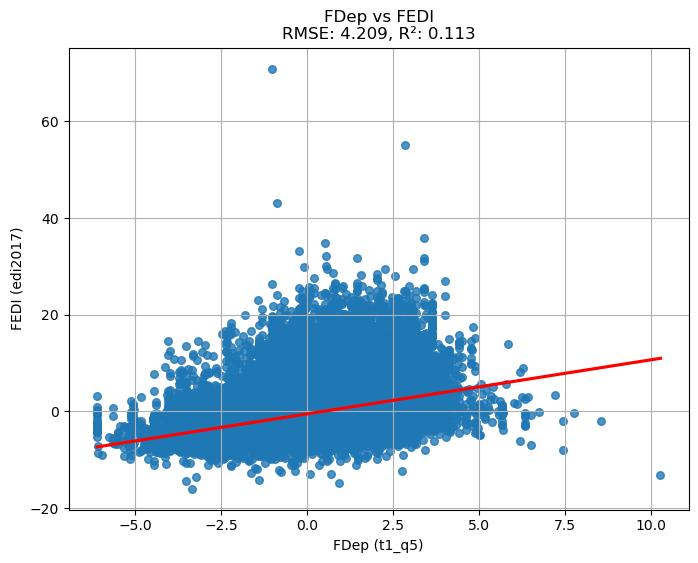

RMSE: 4.209
R²: 0.113


In [97]:
# Plot scatter with regression line
plt.figure(figsize=(8, 6))
sns.regplot(x=x, y=y, ci=None, scatter_kws={"s": 30}, line_kws={"color": "red"})
plt.xlabel("FDep (t1_q5)")
plt.ylabel("FEDI (edi2017)")
plt.title(f"FDep vs FEDI\nRMSE: {rmse:.3f}, R²: {r2:.3f}")
plt.grid(True)

# Show plot
plt.show()

# Print values
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

In [67]:
# Count number of IRIS per category for legends
fdep_counts = merged_df['t1_q5'].value_counts().sort_index()
edi_counts = merged_df['quintileedi2017'].value_counts().sort_index()

print(f"{fdep_counts}")
print(f"{edi_counts}")


t1_q5
1     7256
2    11316
3    12125
4    13320
5    11777
Name: count, dtype: int64
quintileedi2017
1    11668
2    11526
3    11265
4    11027
5    10308
Name: count, dtype: int64
